# ProjetML - Rapport / Expérimentation

### Santhos Arichandra & Krisni Almehdi

In [229]:
%load_ext autoreload
%autoreload 2
from classes import *
from loss import *
from mltools import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data 

In [2]:
############################ USPS DATA ######################################
uspsdatatrain = "./data/USPS_train.txt"
uspsdatatest = "./data/USPS_test.txt"
X_train_usps,Y_train_usps = load_usps(uspsdatatrain)
X_test_usps,Y_test_usps = load_usps(uspsdatatest)

In [3]:
############################ MNIST DATA ######################################
from keras.datasets import mnist
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = mnist.load_data()
mnist_train_X = mnist_train_X.reshape(60000, 784)
mnist_test_X = mnist_test_X.reshape(10000, 784)
mnist_train_X = mnist_train_X.astype('float32')
mnist_test_X = mnist_test_X.astype('float32')

In [4]:
############################ 2 GAUSIENNES DATA ######################################
artix2, artiy2 = gen_arti(data_type=0, nbex=10000)
artiy2 = np.where(artiy2 == -1, 0, 1)

artix2_train, artiy2_train, artix2_test, artiy2_test = [], [], [] ,[]

part = 5 #1/part of the data for test

for i in range(len(artix2)):
    if i%part == 0:
        artix2_test.append(artix2[i])
        artiy2_test.append(artiy2[i])
    artix2_train.append(artix2[i])
    artiy2_train.append(artiy2[i])

artix2_train, artiy2_train, artix2_test, artiy2_test = np.array(artix2_train), np.array(artiy2_train),\
                                                   np.array(artix2_test), np.array(artiy2_test)

In [5]:
############################ 4 GAUSIENNES DATA ######################################
artix4, artiy4 = gen_arti(data_type=1, nbex=10000)
artiy4 = np.where(artiy4 == -1, 0, 1)

artix4_train, artiy4_train, artix4_test, artiy4_test = [], [], [] ,[]

part = 5 #1/part of the data for test

for i in range(len(artix4)):
    if i%part == 0:
        artix4_test.append(artix4[i])
        artiy4_test.append(artiy4[i])
    artix4_train.append(artix4[i])
    artiy4_train.append(artiy4[i])

artix4_train, artiy4_train, artix4_test, artiy4_test = np.array(artix4_train), np.array(artiy4_train),\
                                                   np.array(artix4_test), np.array(artiy4_test)

In [6]:
############################ RANDOM DATA ######################################
trainx = np.random.random((500,2))
trainy = np.where(np.random.random((500,1)) > 0.5, 1, 0)

In [7]:
############################ REGRESSION DATA ######################################
regressionX, regressionY = datasets.make_regression(n_samples=500,
                                      n_features=1,
                                      n_informative=1,
                                      noise=10, random_state=0)
regressionY = np.reshape(regressionY, (len(regressionY), 1))

## Lineaire

<b> Dans un premier temps essayons de voir si comment évolue nos modèles avec des données linéaires.

### Regression

In [8]:
mse = MSELoss()

l1 = Linear(1,1)
net = Sequential([l1])

In [9]:
all_loss = BatchGD(net, mse, regressionX, regressionY, epochs=7, eps=1e-3)

100%|██████████| 7/7 [00:00<00:00, 7907.39it/s]


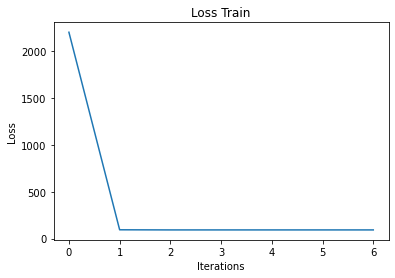

In [10]:
plt.figure()
plt.plot(all_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.show()

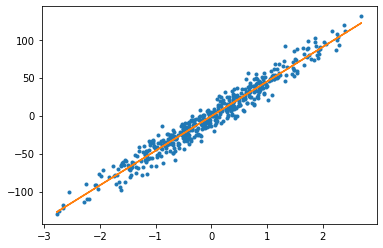

In [11]:
plt.figure()
plt.plot(regressionX, regressionY, '.')
plt.plot(regressionX, regressionX*l1._parameters + l1._biais)
plt.show()

<b> Il s'agit ici de donnée très simple donc il est vraiment simple pour nos modèles de trouver la bonne droite.

### Classification

In [12]:
l2 = Linear(artix2_train.shape[1], 1)
netClassif = Sequential([l2])

In [13]:
all_loss = BatchGD(netClassif, mse, artix2_train, artiy2_train, epochs=15, eps=1e-5)

100%|██████████| 15/15 [00:00<00:00, 2143.89it/s]


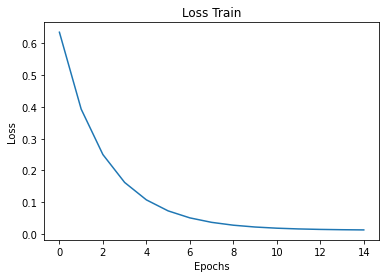

In [14]:
plt.figure()
plt.plot(all_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.show()

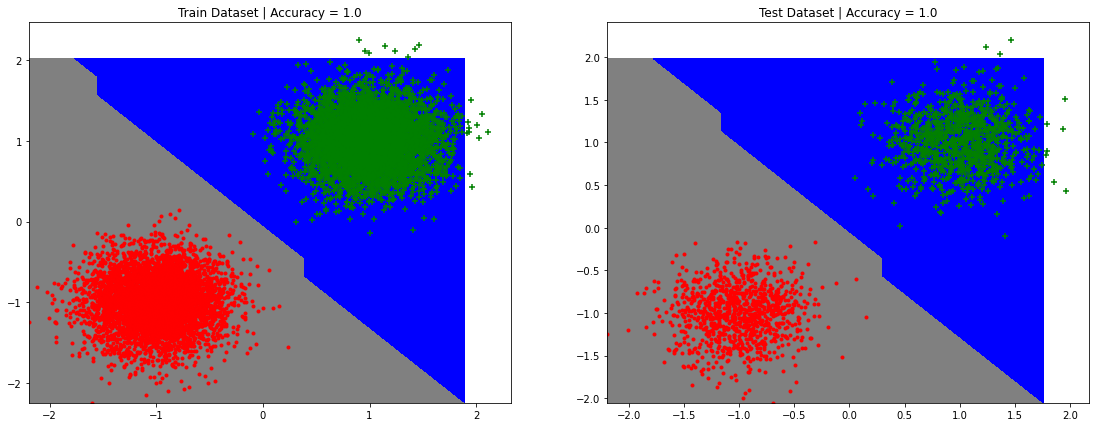

In [32]:
accuClassifLinearTrain, _ = accuracy_linear(netClassif, artix2_train, artiy2_train)
accuClassifLinearTest, _ = accuracy_linear(netClassif, artix2_test, artiy2_test)

plt.figure(figsize=(19,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plot_frontiere(artix2_train, predict_linear, netClassif)
plot_data(artix2_train, artiy2_train)
plt.title(f'Train Dataset | Accuracy = {accuClassifLinearTrain}')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
plot_frontiere(artix2_test, predict_linear, netClassif)
plot_data(artix2_test, artiy2_test)
plt.title(f'Test Dataset | Accuracy = {accuClassifLinearTest}')
plt.show()

## Non Lineaire

<b>A présent concentrons nous sur des données un peu plus complexes et qui sont donc non linéairement séparables.

#### 4 Neurones

<b>On va ici fixer le nombre de neurone à 4 avec un 1 couche cachée. Via ceci nous allons pouvoir regarder ce que nous apporte la variation des autres paramètres.

<b>Observons l'impact que nous avons si nous avons le biais ou pas

In [16]:
mse = MSELoss()

number_neurons = 4

seqNonLinearSansB = Sequential([Linear(len(artix4_train[0]),number_neurons, biais=False),TanH(),Linear(number_neurons,1, biais=False),Sigmoide()])
seqNonLinearAvecB = Sequential([Linear(len(artix4_train[0]),number_neurons, biais=True),TanH(),Linear(number_neurons,1, biais=True),Sigmoide()])

In [17]:
losses_train_BGDSansB = BatchGD(seqNonLinearSansB, mse, artix4_train, artiy4_train, epochs=20, eps=0.001)
losses_train_BGDAvecB = BatchGD(seqNonLinearAvecB, mse, artix4_train, artiy4_train, epochs=20, eps=0.001)

100%|██████████| 20/20 [00:00<00:00, 350.69it/s]


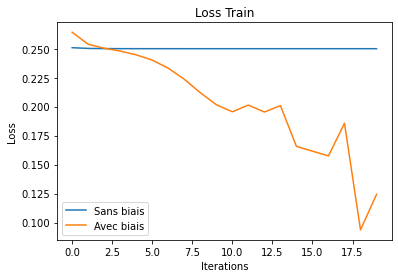

In [18]:
plt.figure()
plt.plot(losses_train_BGDSansB)
plt.plot(losses_train_BGDAvecB)
plt.legend(['Sans biais', 'Avec biais'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.show()

<b>Sur ce graphe nous avons les loss pour le modèle avec et sans biais
Et on constate très clairement la grosse différence que le biais nous apporte. C'était prédictible Nous allons donc par la suite lancer nos modèles avec des biais

In [19]:
seqNonLinearSansB = Sequential([Linear(len(artix4_train[0]),number_neurons, biais=False),TanH(),Linear(number_neurons,1, biais=False),Sigmoide()])
seqNonLinearAvecB = Sequential([Linear(len(artix4_train[0]),number_neurons, biais=True),TanH(),Linear(number_neurons,1, biais=True),Sigmoide()])

In [20]:
losses_train_MBGDSansB = MiniBatchGD(seqNonLinearSansB, mse, artix4_train, artiy4_train, 100, epochs=20, eps=0.001)
losses_train_MBGDAvecB = MiniBatchGD(seqNonLinearAvecB, mse, artix4_train, artiy4_train, 100, epochs=20, eps=0.001)

100%|██████████| 20/20 [00:00<00:00, 43.55it/s]


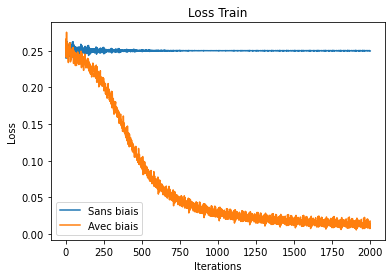

In [21]:
plt.figure()
plt.plot(losses_train_MBGDSansB)
plt.plot(losses_train_MBGDAvecB)
plt.legend(['Sans biais', 'Avec biais'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.show()

<b> Il s'agit de la même expérience que précedemment, sauf que nous avons utiliser des mini batchs nous permettant d'avoir des temps d'exécutions.

De plus via le mini batchs on constate encore plus que sans le biais après seulement un nombre d'itérations faible il ne plus s'améliorer du à la contrainte du non biais.

In [22]:
accuTrainSansB, yhat = accuracy_linear(seqNonLinearSansB, artix4_train, artiy4_train)
accuTrainAvecB, yhat = accuracy_linear(seqNonLinearAvecB, artix4_test, artiy4_test)

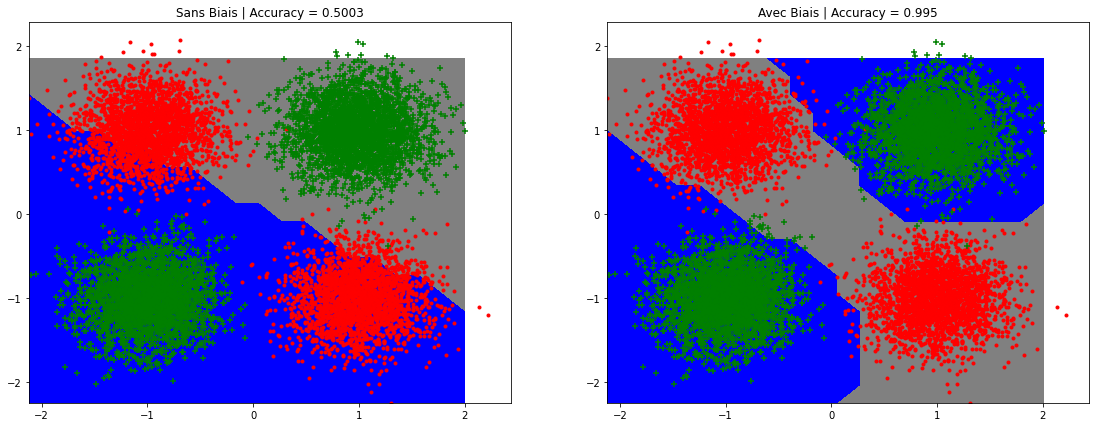

In [23]:
plt.figure(figsize=(19,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plot_frontiere(artix4_train, predict_linear, seqNonLinearSansB)
plot_data(artix4_train, artiy4_train)
plt.title(f'Sans Biais | Accuracy = {accuTrainSansB}')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
plot_frontiere(artix4_train, predict_linear, seqNonLinearAvecB)
plot_data(artix4_train, artiy4_train)
plt.title(f'Avec Biais | Accuracy = {accuTrainAvecB}')
plt.show()

<b> De manière plus visuel, il n'y a pas photo.

<b> Maintenant que nous avons tester le biais, regardons un peu plus en details le nombre de neurones necessaire pour avoir les meilleurs résultats ( avec 1 seule couche cachée )

In [24]:
seqNonLinear2N = Sequential([Linear(len(artix4_train[0]),2, biais=True),TanH(),Linear(2,1, biais=True),Sigmoide()])
seqNonLinear4N = Sequential([Linear(len(artix4_train[0]),4, biais=True),TanH(),Linear(4,1, biais=True),Sigmoide()])
seqNonLinear5N = Sequential([Linear(len(artix4_train[0]),5, biais=True),TanH(),Linear(5,1, biais=True),Sigmoide()])
seqNonLinear10N = Sequential([Linear(len(artix4_train[0]),10, biais=True),TanH(),Linear(10,1, biais=True),Sigmoide()])
seqNonLinear20N = Sequential([Linear(len(artix4_train[0]),20, biais=True),TanH(),Linear(20,1, biais=True),Sigmoide()])

In [25]:
loss2N = BatchGD(seqNonLinear2N, mse, artix4_train, artiy4_train, epochs=15, eps=0.001)
loss4N = BatchGD(seqNonLinear4N, mse, artix4_train, artiy4_train, epochs=15, eps=0.001)
loss5N = BatchGD(seqNonLinear5N, mse, artix4_train, artiy4_train, epochs=15, eps=0.001)
loss10N = BatchGD(seqNonLinear10N, mse, artix4_train, artiy4_train, epochs=15, eps=0.001)
loss20N = BatchGD(seqNonLinear20N, mse, artix4_train, artiy4_train, epochs=15, eps=0.001)

100%|██████████| 15/15 [00:00<00:00, 87.72it/s]


In [26]:
acculoss2N, _ = accuracy_linear(seqNonLinear2N, artix4_test, artiy4_test)
acculoss4N, _ = accuracy_linear(seqNonLinear4N, artix4_test, artiy4_test)
acculoss5N, _ = accuracy_linear(seqNonLinear5N, artix4_test, artiy4_test)
acculoss10N,_ = accuracy_linear(seqNonLinear10N, artix4_test, artiy4_test)
acculoss20N,_ = accuracy_linear(seqNonLinear20N, artix4_test, artiy4_test)

#### Plot avec le dataset Test

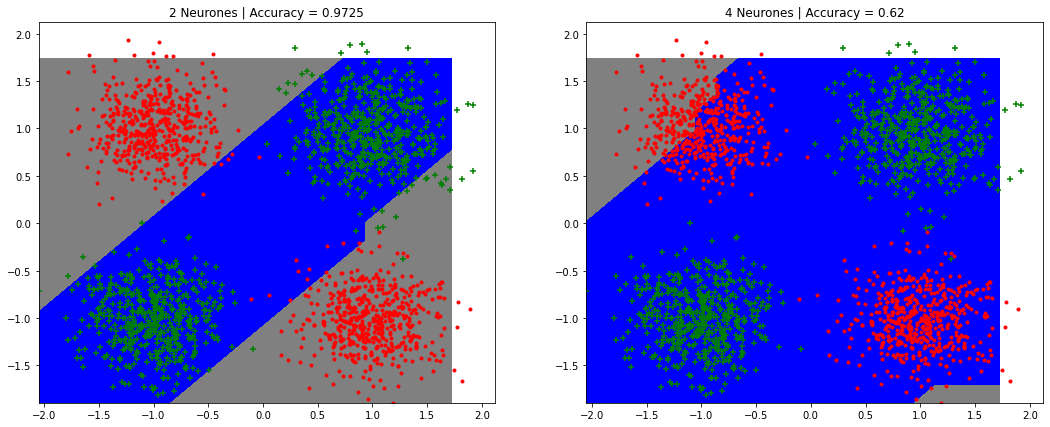

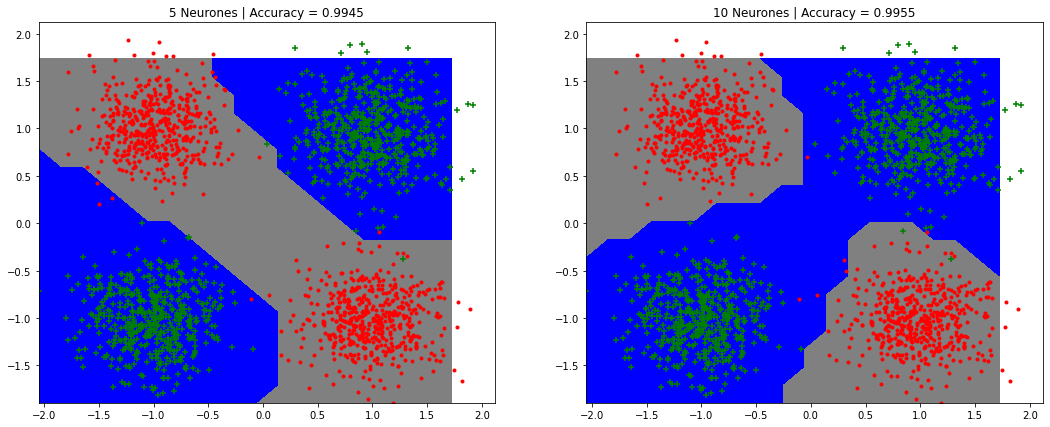

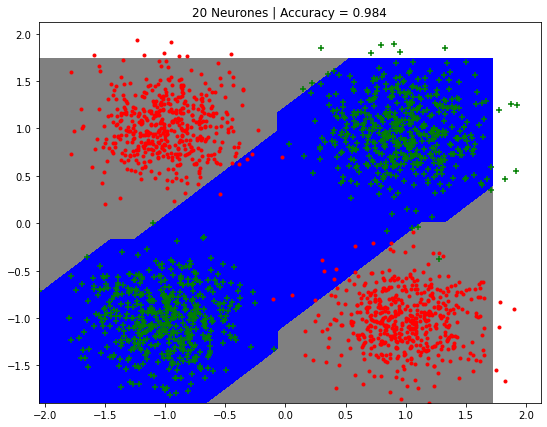

In [27]:
plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear2N)
plot_data(artix4_test, artiy4_test)
plt.title(f'2 Neurones | Accuracy = {acculoss2N}')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear4N)
plot_data(artix4_test, artiy4_test)
plt.title(f'4 Neurones | Accuracy = {acculoss4N}')
plt.show()

plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear5N)
plot_data(artix4_test, artiy4_test)
plt.title(f'5 Neurones | Accuracy = {acculoss5N}')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear10N)
plot_data(artix4_test, artiy4_test)
plt.title(f'10 Neurones | Accuracy = {acculoss10N}')
plt.show()

plt.figure(figsize=(9,7))
plot_frontiere(artix4_test, predict_linear, seqNonLinear20N)
plot_data(artix4_test, artiy4_test)
plt.title(f'20 Neurones | Accuracy = {acculoss20N}')
plt.show()

<b> Avoir 10 neurones dans notre couche nous permet clairement d'avoir les meilleurs résultas

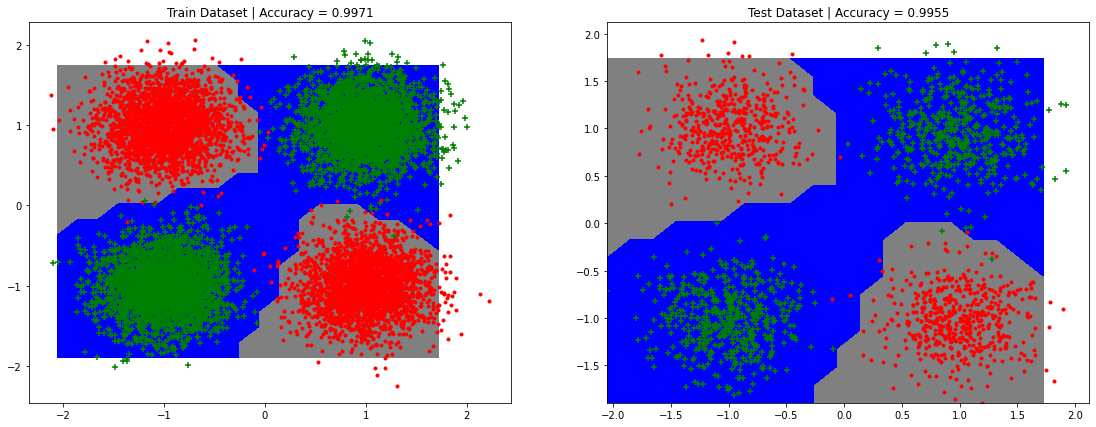

In [28]:
acculossTrain10N, yhat = accuracy_linear(seqNonLinear10N, artix4_train, artiy4_train)
acculossTest10N, yhat = accuracy_linear(seqNonLinear10N, artix4_test, artiy4_test)

plt.figure(figsize=(19,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear10N)
plot_data(artix4_train, artiy4_train)
plt.title(f'Train Dataset | Accuracy = {acculossTrain10N}')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
plot_frontiere(artix4_test, predict_linear, seqNonLinear10N)
plot_data(artix4_test, artiy4_test)
plt.title(f'Test Dataset | Accuracy = {acculossTest10N}')
plt.show()

# Multi-Classe

## MSE VS CrossEntropy

In [61]:
mse = MSELoss()
ce = CrossEntropyLogSoftmax()
dimensionX = len(mnist_train_X[0])
number_output = 10

In [62]:
mnist_train_y_OH = one_hot(mnist_train_y)
mnist_test_y_OH = one_hot(mnist_test_y)

### Nombres de neurones

#### 128N -> 64N -> 10N

##### Non normalisé

In [31]:
number_neurons_layer1 = 128
number_neurons_layer2 = 64

seqMSE1 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE1 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [32]:
all_loss_MSE1 = MiniBatchGD(seqMSE1, mse, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE1 = MiniBatchGD(seqCE1, ce, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


In [33]:
accu_MSE1 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqMSE1)
accu_CE1 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqCE1)

print(f'Accuracy MSE : {accu_MSE1}')
print(f'Accuracy CE : {accu_CE1}')

Accuracy MSE : 0.8375
Accuracy CE : 0.8831


##### Normalisé

In [40]:
number_neurons_layer1 = 128
number_neurons_layer2 = 64

seqMSE1 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE1 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [41]:
all_loss_MSE1_norm = MiniBatchGD(seqMSE1, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE1_norm = MiniBatchGD(seqCE1, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


In [42]:
accu_MSE1_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE1)
accu_CE1_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE1)

print(f'Accuracy MSE : {accu_MSE1_norm}')
print(f'Accuracy CE : {accu_CE1_norm}')

Accuracy MSE : 0.8793
Accuracy CE : 0.9187


#### 256N -> 128N -> 10N

##### Non normalisé

In [43]:
number_neurons_layer1 = 256
number_neurons_layer2 = 128

seqMSE2 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE2 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [44]:
all_loss_MSE2 = MiniBatchGD(seqMSE2, mse, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE2 = MiniBatchGD(seqCE2, ce, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


In [45]:
accu_MSE2 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqMSE2)
accu_CE2 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqCE2)

print(f'Accuracy MSE : {accu_MSE2}')
print(f'Accuracy CE : {accu_CE2}')

Accuracy MSE : 0.8275
Accuracy CE : 0.8907


##### Normalisé

In [230]:
number_neurons_layer1 = 256
number_neurons_layer2 = 128

seqMSE2 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE2 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [233]:
all_loss_MSE2_norm = MiniBatchGD(seqMSE2, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE2_norm = MiniBatchGD(seqCE2, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


In [232]:
accu_MSE2_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE2)
accu_CE2_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE2)

print(f'Accuracy MSE : {accu_MSE2_norm}')
print(f'Accuracy CE : {accu_CE2_norm}')

Accuracy MSE : 0.0937
Accuracy CE : 0.9183


#### 512N -> 256N -> 10N

##### Non normalisé

In [ ]:
number_neurons_layer1 = 512
number_neurons_layer2 = 256

seqMSE3 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE3 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [ ]:
all_loss_MSE3 = MiniBatchGD(seqMSE3, mse, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE3 = MiniBatchGD(seqCE3, ce, mnist_train_X, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


In [ ]:
accu_MSE3 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqMSE3)
accu_CE3 = accuracy_argmax(mnist_test_X, mnist_test_y_OH, seqCE3)

print(f'Accuracy MSE : {accu_MSE3}')
print(f'Accuracy CE : {accu_CE3}')

Accuracy MSE : 0.8375
Accuracy CE : 0.8917


##### Normalisé

In [39]:
number_neurons_layer1 = 512
number_neurons_layer2 = 256

seqMSE3 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE3 = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [40]:
all_loss_MSE3_norm = MiniBatchGD(seqMSE3, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE3_norm = MiniBatchGD(seqCE3, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [02:20<00:00,  7.01s/it]


In [41]:
accu_MSE3_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE3)
accu_CE3_norm = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE3)

print(f'Accuracy MSE : {accu_MSE3_norm}')
print(f'Accuracy CE : {accu_CE3_norm}')

Accuracy MSE : 0.8059
Accuracy CE : 0.9153


### Comparaison

In [280]:
d = {'Non normalise' : [accu_MSE1, accu_CE1, accu_MSE2, accu_CE2, accu_MSE3, accu_CE3], 'Normalise' : [accu_MSE1_norm, accu_CE1_norm, accu_MSE2_norm, accu_CE2_norm, accu_MSE3_norm, accu_CE3_norm]}

errors = 1 - pd.DataFrame(data=d, index=['MSE 128/64', 'CE 128/64', 'MSE 256/128', 'CE 256/128', 'MSE 512/256', 'CE 512/256'])

In [281]:
errors

,Non normalise,Normalise
MSE 128/64,0.1313,0.1229
CE 128/64,0.1190,0.0844
MSE 256/128,0.1520,0.1124
CE 256/128,0.1081,0.0788
MSE 512/256,0.1625,0.0914
CE 512/256,0.1083,0.0783


<b> On s'apercoit ici que normaliser permet d'avoir un gain bien plus important. On s'en doutait evidemment mais il est interessant de voir son impact 

In [289]:
diff = errors['Non normalise'] - errors['Normalise']
print(diff.values.mean())
diff

0.035499999999999955


MSE 128/64     0.0084
CE 128/64      0.0346
MSE 256/128    0.0396
CE 256/128     0.0293
MSE 512/256    0.0711
CE 512/256     0.0300
dtype: float64

<b> On constate que son impact est énorme avec environ 3% de plus en accuracy en moyenne. Surtout pour le MSE 512/256 avec plus de 7% !

<b> A présent essayons de voir si le nombre de couche permet d'avoir de meilleur résultat. Nous allons utiliser pour cela la base de 512 neurones pour la 1ere couche, 256 neurones pour la 2ème  
et on va en ajouter petits à petits pour voir les différences. 

### Nombre de couche

#### 2 couches

In [234]:
number_neurons_layer1 = 512
number_neurons_layer2 = 256

seqMSE2C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output), Sigmoide()])

seqCE2C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_output)])

In [235]:
all_loss_MSE2C = MiniBatchGD(seqMSE2C, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE2C = MiniBatchGD(seqCE2C, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


In [236]:
accu_MSE2C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE2C)
accu_CE2C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE2C)

print(f'Accuracy MSE : {accu_MSE2C}')
print(f'Accuracy CE : {accu_CE2C}')

Accuracy MSE : 0.7982
Accuracy CE : 0.9195


#### 3 couches

In [50]:
number_neurons_layer1 = 512
number_neurons_layer2 = 256
number_neurons_layer3 = 128

seqMSE3C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_neurons_layer3),TanH(),
                    Linear(number_neurons_layer3,number_output), Sigmoide()])

seqCE3C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_neurons_layer3),TanH(),
                    Linear(number_neurons_layer3,number_output)])

In [51]:
all_loss_MSE3C = MiniBatchGD(seqMSE3C, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE3C = MiniBatchGD(seqCE3C, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [02:24<00:00,  7.22s/it]


In [52]:
accu_MSE3C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE3C)
accu_CE3C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE3C)

print(f'Accuracy MSE : {accu_MSE3C}')
print(f'Accuracy CE : {accu_CE3C}')

Accuracy MSE : 0.8649
Accuracy CE : 0.9038


#### 4 couches

In [47]:
number_neurons_layer1 = 512
number_neurons_layer2 = 256
number_neurons_layer3 = 128
number_neurons_layer4 = 64

seqMSE4C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_neurons_layer3),TanH(),
                    Linear(number_neurons_layer3,number_neurons_layer4),TanH(),
                    Linear(number_neurons_layer4,number_output), Sigmoide()])

seqCE4C = Sequential([Linear(dimensionX,number_neurons_layer1),TanH(),
                    Linear(number_neurons_layer1,number_neurons_layer2),TanH(),
                    Linear(number_neurons_layer2,number_neurons_layer3),TanH(),
                    Linear(number_neurons_layer3,number_neurons_layer4),TanH(),
                    Linear(number_neurons_layer4,number_output)])

In [48]:
all_loss_MSE4C = MiniBatchGD(seqMSE4C, mse, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)
all_loss_CE4C = MiniBatchGD(seqCE4C, ce, mnist_train_X/255, mnist_train_y_OH, 200, epochs=20, eps=10e-5)

100%|██████████| 20/20 [02:39<00:00,  7.97s/it]


In [49]:
accu_MSE4C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqMSE4C)
accu_CE4C = accuracy_argmax(mnist_test_X/255, mnist_test_y_OH, seqCE4C)

print(f'Accuracy MSE : {accu_MSE4C}')
print(f'Accuracy CE : {accu_CE4C}')

Accuracy MSE : 0.8649
Accuracy CE : 0.8898


### Comparaison

In [53]:
d = {'MSE' : [accu_MSE2C, accu_MSE3C, accu_MSE4C], 'CE' : [accu_CE2C, accu_CE3C, accu_CE4C]}

errors = 1 - pd.DataFrame(data=d, index=['2C', '3C', '4C'])

In [55]:
errors

,MSE,CE
2C,0.1277,0.0848
3C,0.1351,0.0962
4C,0.1351,0.1102


<b> On constate ici qu'avoir 2 couches nous permet d'avoir les meilleurs résultats et comme avant on s'apercoit clairement de la différence entre la MSE et la CE  
  
Avec plus de couches nous avons bien plus de parametres et donc il faut une quantité ENORME de donnée pour avoir de meilleur c'est ce qui peut expliquer que 2 couches  
donne les meilleurs résultats

In [237]:
y_pred = np.argmax(seqCE2C.forward(mnist_test_X/255), axis=1)
cf_matrix = confusion_matrix(mnist_test_y, y_pred)

In [238]:
cf_matrix

array([[ 943,    1,    2,    3,    1,   10,   13,    3,    3,    1],
       [   0, 1112,    6,    5,    1,    1,    2,    0,    8,    0],
       [   6,    4,  939,   19,    9,    4,   15,    8,   22,    6],
       [   4,    2,   18,  917,    1,   22,    3,   10,   22,   11],
       [   3,    0,    9,    3,  916,    4,    9,    5,    7,   26],
       [  10,    2,    1,   25,    6,  803,   12,    3,   25,    5],
       [  12,    3,    8,    2,   18,   13,  895,    1,    5,    1],
       [   2,   13,   22,    6,   11,    2,    1,  930,    7,   34],
       [  10,    1,   19,   29,   11,   32,   11,    6,  839,   16],
       [   6,    6,    6,   14,   32,    7,    5,   24,    8,  901]],
      dtype=int64)

<AxesSubplot:>

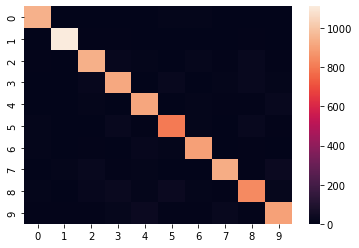

In [240]:
sns.heatmap(cf_matrix, annot=False)

# Encodeur

### Neural Networks

In [65]:
mnist_train_X_norm = mnist_train_X/255

In [137]:
ind = 111

ind_test = []
ind_test.append((np.where(mnist_test_y == 0)[0][ind]))
ind_test.append((np.where(mnist_test_y == 1)[0][ind]))
ind_test.append((np.where(mnist_test_y == 2)[0][ind]))
ind_test.append((np.where(mnist_test_y == 3)[0][ind]))
ind_test.append((np.where(mnist_test_y == 4)[0][ind]))
ind_test.append((np.where(mnist_test_y == 5)[0][ind]))
ind_test.append((np.where(mnist_test_y == 6)[0][ind]))
ind_test.append((np.where(mnist_test_y == 7)[0][ind]))
ind_test.append((np.where(mnist_test_y == 8)[0][ind]))
ind_test.append((np.where(mnist_test_y == 9)[0][ind]))

### Nombres de neurones

### 100N

In [69]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 100
number_neurons_layer2 = 10

seqEncoder100 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH()]
seqDecoder100 = [Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net100 = Sequential(seqEncoder100 + seqDecoder100)
ce = BinaryCrossEntropy()

loss100 = MiniBatchGD(net100, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=200, eps=1e-4, verbose=False)

100%|██████████| 200/200 [18:59<00:00,  5.70s/it]


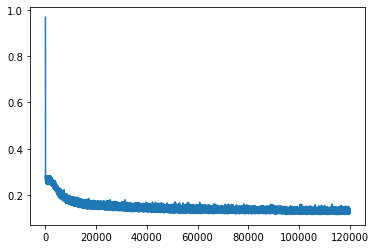

In [70]:
plt.figure()
plt.plot(loss100)
plt.show()

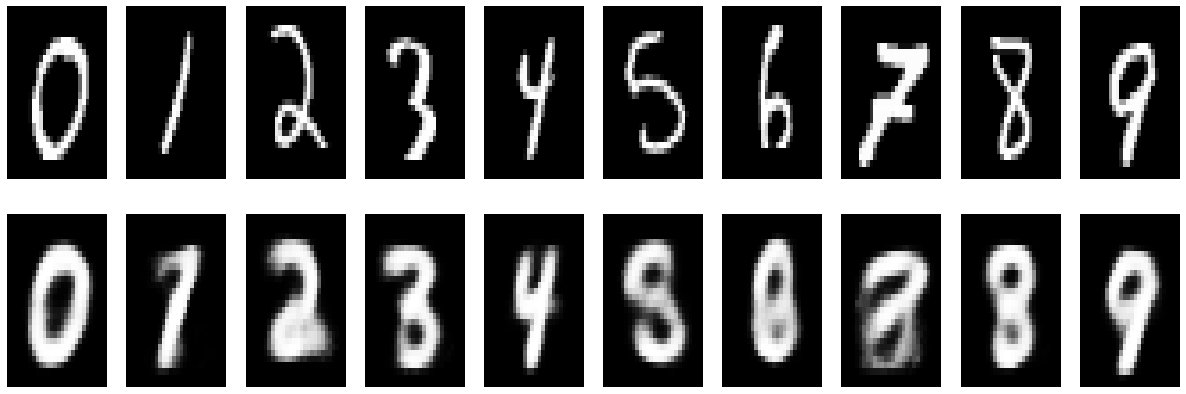

In [138]:
show_mnist_compare_multi(mnist_test_X[ind_test], net100.forward(mnist_test_X[ind_test]))

In [118]:
X_reconstruted_100 = net100.forward(mnist_test_X)
accuracy_argmax(mnist_test_X, X_reconstruted_100, seqCE2C)

0.0

<b> Les résultats sont assez corrects mais on est bien loin d'une reconstruction très précise des chiffres même si certain chiffre sont assez clair

### 200N

In [72]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 200
number_neurons_layer2 = 10

seqEncoder200 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH()]
seqDecoder200 = [Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net200 = Sequential(seqEncoder200 + seqDecoder200)
ce = BinaryCrossEntropy()

loss200 = MiniBatchGD(net200, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=200, eps=1e-4, verbose=False)

100%|██████████| 200/200 [24:10<00:00,  7.25s/it]


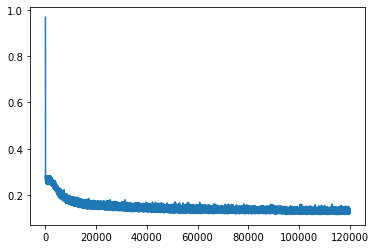

In [73]:
plt.figure()
plt.plot(loss100)
plt.show()

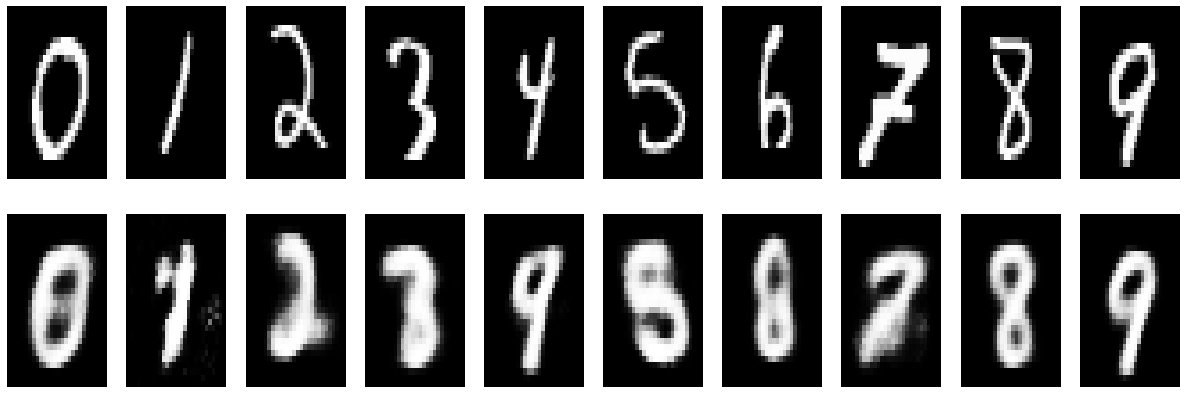

In [139]:
show_mnist_compare_multi(mnist_test_X[ind_test], net200.forward(mnist_test_X[ind_test]))

<b> Une nette amélioration avec les valeurs comme 2 qui sont maintenement bien plus clair et perceptible

In [ ]:
X_reconstruted_200 = net200.forward(mnist_test_X)
accuracy_argmax(mnist_test_X, X_reconstruted_200, seqCE2C)

<b> Passons a des modèles à deux couches on devrait pouvoir avoir de meilleur résultat

#### 128N -> 64N

In [75]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoder128 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoder128 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net128 = Sequential(seqEncoder128 + seqDecoder128)
ce = BinaryCrossEntropy()

loss128 = MiniBatchGD(net128, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=200, eps=1e-4, verbose=False)

100%|██████████| 200/200 [21:00<00:00,  6.30s/it]


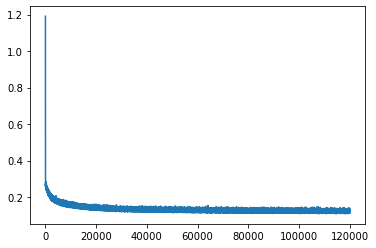

In [76]:
plt.figure()
plt.plot(loss128)
plt.show()

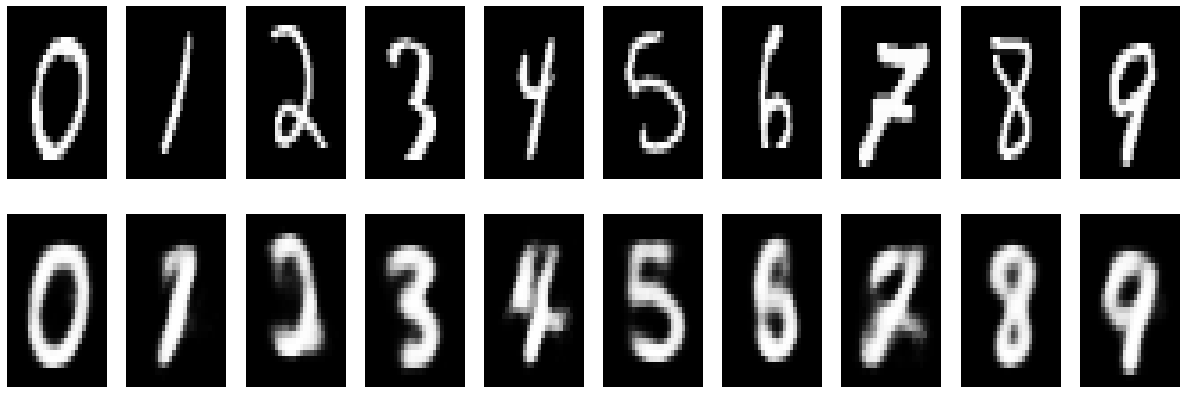

In [140]:
show_mnist_compare_multi(mnist_test_X[ind_test], net128.forward(mnist_test_X[ind_test]))

In [ ]:
X_reconstruted_128 = net128.forward(mnist_test_X)
accuracy_argmax(mnist_test_X, X_reconstruted_128, seqCE2C)

<b> Les résultat sont certes meilleurs que ceux précedent mais pas aussi marquant que nous l'espérons

#### 256N -> 128N

In [78]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 256
number_neurons_layer2 = 128
number_neurons_layer3 = 10

seqEncoder256 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoder256 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net256 = Sequential(seqEncoder256 + seqDecoder256)
ce = BinaryCrossEntropy()

loss256 = MiniBatchGD(net256, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=200, eps=1e-4, verbose=False)

100%|██████████| 200/200 [33:57<00:00, 10.19s/it]


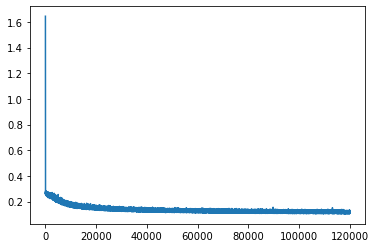

In [79]:
plt.figure()
plt.plot(loss256)
plt.show()

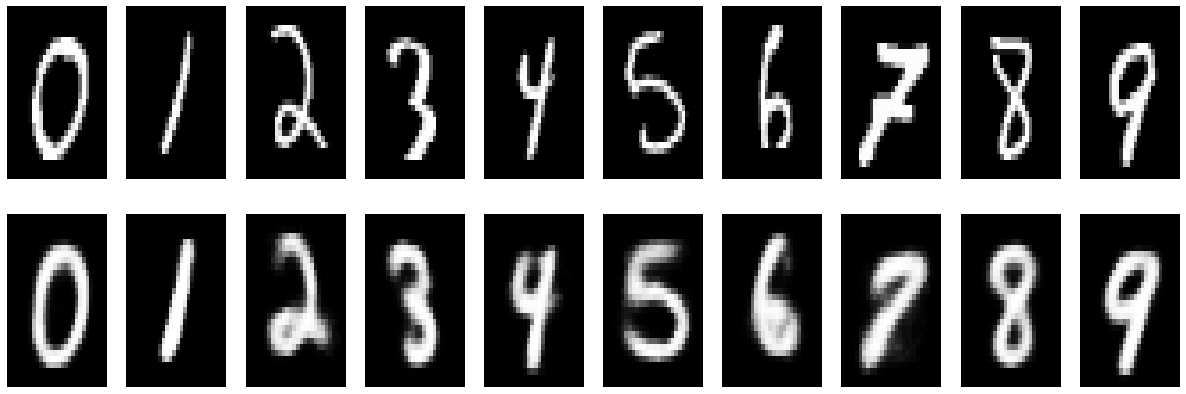

In [141]:
show_mnist_compare_multi(mnist_test_X[ind_test], net256.forward(mnist_test_X[ind_test]))

In [ ]:
X_reconstruted_256 = net256.forward(mnist_test_X)
accuracy_argmax(mnist_test_X, X_reconstruted_256, seqCE2C)

<b> Par contre avec cette architecture l'évolution est bien plus nette. On peut clairement distiguer tous les chiffres.

<b>A présent prenons notre dernier modèle et regardons si nous pouvons réduire les dimensions tout en gardant la disparité des données  
quand nous les passons sur des modèles de reduction de dimension comme t-SNE

### t-SNE - Visualisation

#### Données de base

c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


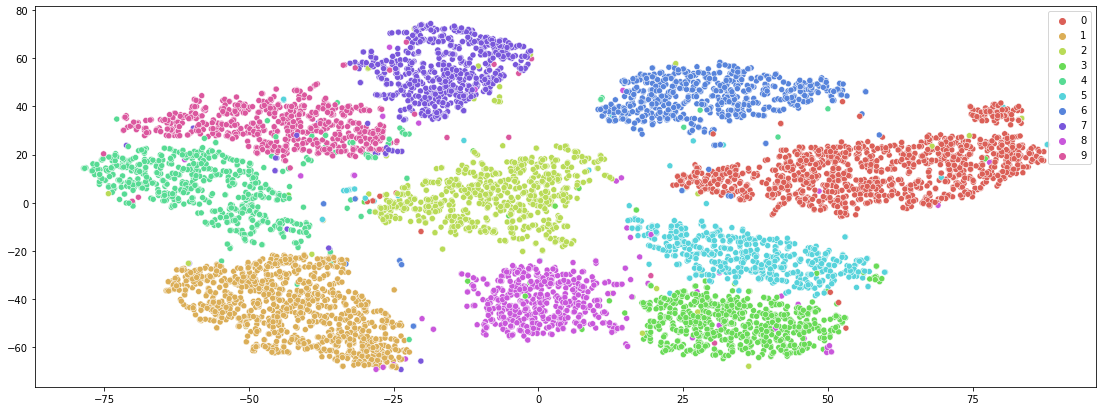

In [35]:
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(X_train_usps)

plt.figure(figsize=(19,7))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = Y_train_usps, palette = sns.hls_palette(10), legend = 'full')
plt.show()

<b> Ici il s'agit des données MNIST de base donc 784 dimensions réduit en 2 dimensions  
  
On peut ici clairement distinguer toutes les classes  
  
Regardons si c'est le cas avec 10 et ensuite avec 2 ce qui nous permettrait de passer outre t-SNE pour de la reduction, ce qui serait interessant.

#### Données avec 10 dimensions 

In [115]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 512
number_neurons_layer2 = 128
number_neurons_layer3 = 10

seqEncoder512 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH()]
seqDecoder512 = [Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net512 = Sequential(seqEncoder512 + seqDecoder512)
ce = BinaryCrossEntropy()

all_loss = MiniBatchGD(net512, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [27:48<00:00, 16.69s/it]


(10000, 128)


c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\santh\anaconda3\envs\ml3\li

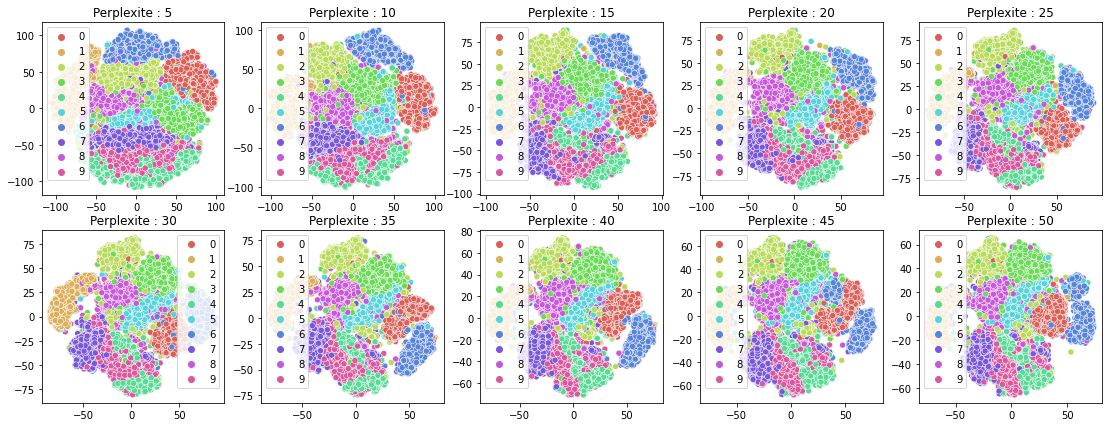

In [116]:
encoder = Sequential(seqEncoder512)
mnist_X_10 = encoder.forward(mnist_test_X)
print(mnist_X_10.shape)
ind = 1
plt.figure(figsize=(19,7))
for l in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    tsne = TSNE(n_components = 2, random_state=0, perplexity=l)
    tsne_res = tsne.fit_transform(mnist_X_10)
    plt.subplot(2, 5, ind)
    sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = mnist_test_y, palette = sns.hls_palette(10), legend = 'full')
    plt.title(f'Perplexite : {l}')
    ind += 1
plt.show()

<b> Avec une réduction en 10 dimensions, nous constatons que nous conservons toujours les informations, nous permettant de pouvoir distinguer les différentes classes

#### Données avec 2 dimensions 

In [188]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 512
number_neurons_layer2 = 128
number_neurons_layer3 = 2

seqEncoder512_2D = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoder512_2D = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

net512_2D = Sequential(seqEncoder512_2D + seqDecoder512_2D)
ce = BinaryCrossEntropy()

loss2D = MiniBatchGD(net512_2D, ce, mnist_train_X_norm, mnist_train_X_norm, 100, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [28:45<00:00, 17.25s/it]


(10000, 2)


<AxesSubplot:>

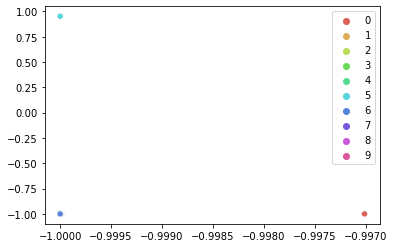

In [201]:
encoder2D = Sequential(seqEncoder512_2D)
mnist2D = encoder2D.forward(mnist_test_X/255)
print(mnist2D.shape)
sns.scatterplot(x = mnist2D[:,0], y = mnist2D[:,1], hue = mnist_test_y, palette = sns.hls_palette(10), legend = 'full')

<b> On constate avec une grande surprise qu'une réduction en 2 dimensions résulte de 3 points où toutes les valeurs ce situe sur un des 3 points.  
Il n'est donc pas possible de faire une réduction en 2D et de conserver assez d'informations pour pouvoir départager les différentes classes  
  
Toutefois avec 10 dimensions nous pouvons et cette expérience nous montre que nous pouvons régler la problème de la curse of dimensionnality via l'usage d'AutoEncodeur

<b> A présent essayons de nous intéressé aux données bruitées et dans la capacité de l'autoEncodeur à extraire l'informations importante.  

### Données Bruités

<b> Nous allons appliquer 2 types de bruits, un bruit gaussien et un bruit salt and pepper.  
  
Nous allons essayer jusqu'à quel degré nos modèles peuvent retirer les informations encombrantes

#### Gaussien 0.2

In [148]:
X_G02 = add_noise_gaussien(mnist_train_X_norm, mean=0, std=1, p=0.2)
X_G02Test = add_noise_gaussien(mnist_test_X/255, mean=0, std=1, p=0.2)


In [82]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderG02 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderG02 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netG02 = Sequential(seqEncoderG02 + seqDecoderG02)
ce = BinaryCrossEntropy()

lossG02 = MiniBatchGD(netG02, ce, X_G02, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:24<00:00,  8.05s/it]


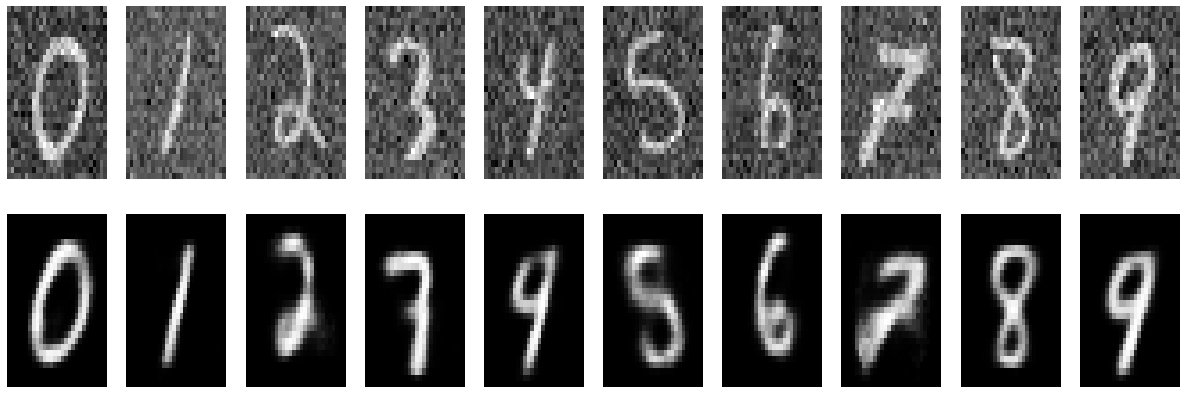

In [149]:
show_mnist_compare_multi(X_G02Test[ind_test], netG02.forward(X_G02Test[ind_test]))

<b> Avec un bruit peu presents nous arrivons a extraire les chiffres avec toute de même quelque petites difficulté pour certaines valeurs

#### Gaussien 0.4

In [150]:
X_G04 = add_noise_gaussien(mnist_train_X_norm, mean=0, std=1, p=0.4)
X_G04Test = add_noise_gaussien(mnist_test_X/255, mean=0, std=1, p=0.4)


In [84]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderG04 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderG04 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netG04 = Sequential(seqEncoderG04 + seqDecoderG04)
ce = BinaryCrossEntropy()

lossG04 = MiniBatchGD(netG04, ce, X_G04, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:32<00:00,  8.13s/it]


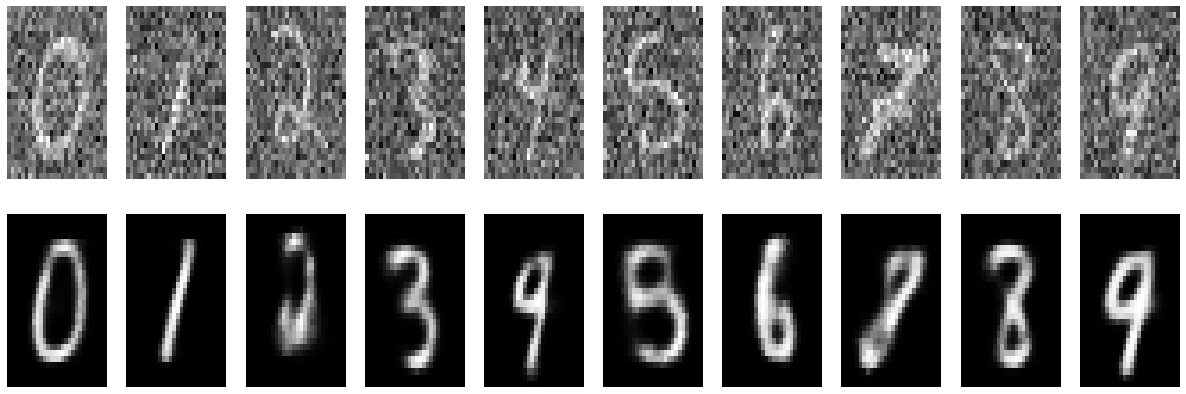

In [151]:
show_mnist_compare_multi(X_G04Test[ind_test], netG04.forward(X_G04Test[ind_test]))

<b> A .4 nous commençons à avoir quelque difficulté comme pour le 4 ou le 7, avoir plus de 0.4 risque d'être assez compliquer pour pouvoir récupérer les informations.  
Testons cela de suite 

#### Gaussien 0.6

In [152]:
X_G06 = add_noise_gaussien(mnist_train_X_norm, mean=0, std=1, p=0.6)
X_G06Test = add_noise_gaussien(mnist_test_X/255, mean=0, std=1, p=0.6)


In [112]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 256
number_neurons_layer2 = 128
number_neurons_layer3 = 10

seqEncoderG06 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderG06 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netG06 = Sequential(seqEncoderG06 + seqDecoderG06)
ce = BinaryCrossEntropy()

lossG06 = MiniBatchGD(netG06, ce, X_G06, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [20:29<00:00, 12.29s/it]


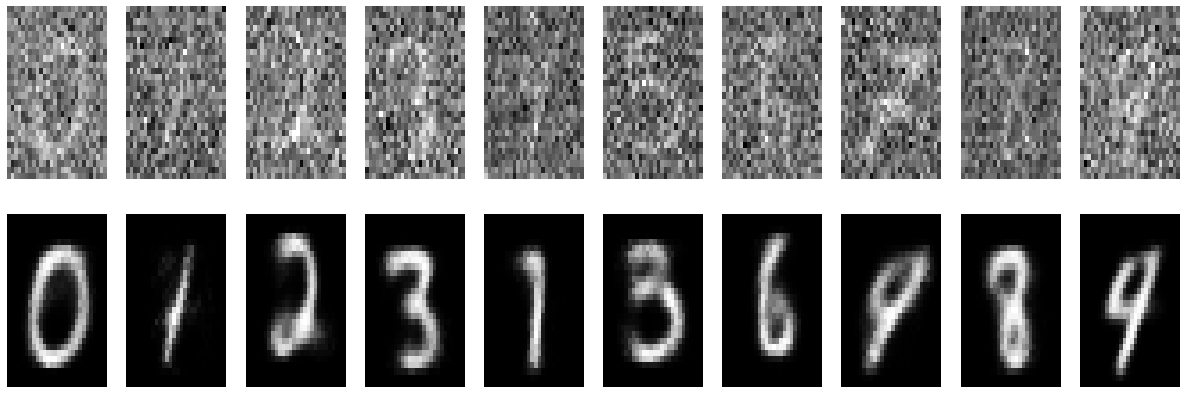

In [153]:
show_mnist_compare_multi(X_G06Test[ind_test], netG06.forward(X_G06Test[ind_test]))

<b> Certes ce n'est pas de très bonnes ectraction mais pour un bruit à 60% ca reste tout de même assez incroyable, que nous arrivons a extraire des informations

#### Gaussien 0.8

In [154]:
X_G08 = add_noise_gaussien(mnist_train_X_norm, mean=0, std=1, p=0.8)
X_G08Test = add_noise_gaussien(mnist_test_X/255, mean=0, std=1, p=0.8)


In [88]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderG06 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderG06 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netG08 = Sequential(seqEncoderG06 + seqDecoderG06)
ce = BinaryCrossEntropy()

lossG08 = MiniBatchGD(netG06, ce, X_G08, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:21<00:00,  8.01s/it]


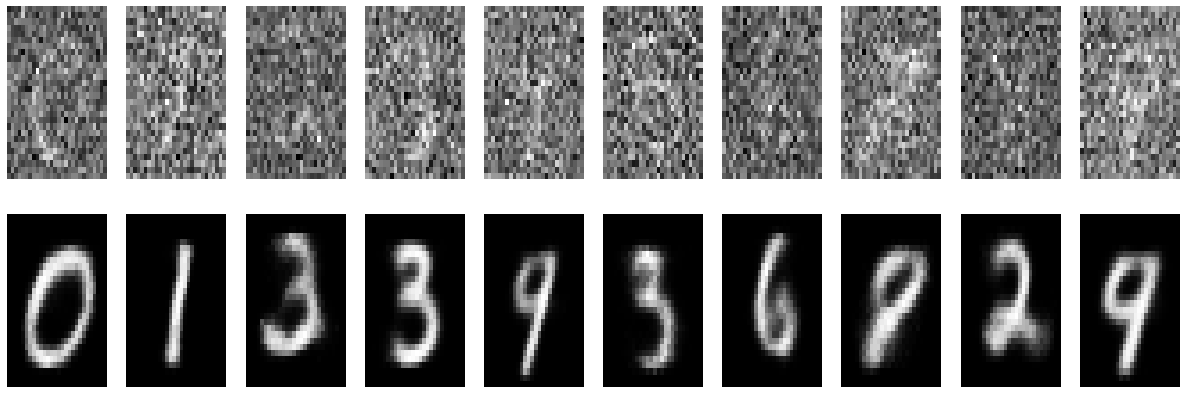

In [155]:
show_mnist_compare_multi(X_G08Test[ind_test], netG06.forward(X_G08Test[ind_test]))

<b> On constate clairement des valeurs qui se repete mais ca vraiment très bon de pouvoir recuperer certaines informations à 80%  
Le bémol tout de même c'est aue donc on a aussi des informations ici qui induisent à de mauvais valeur ca montre tout de même les patterns que certains chiffres partagent.

<b> Passons à présent à Salt and Pepper

#### Salt Pepper 0.2

In [156]:
X_SPO2 = add_noise_pepper(mnist_train_X_norm, p=0.2)
X_SPO2Test = add_noise_pepper(mnist_test_X/255, p=0.2)


In [90]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderSP02 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderSP02 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netSP02 = Sequential(seqEncoderSP02 + seqDecoderSP02)
ce = BinaryCrossEntropy()

lossSP02 = MiniBatchGD(netSP02, ce, X_SPO2, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:17<00:00,  7.97s/it]


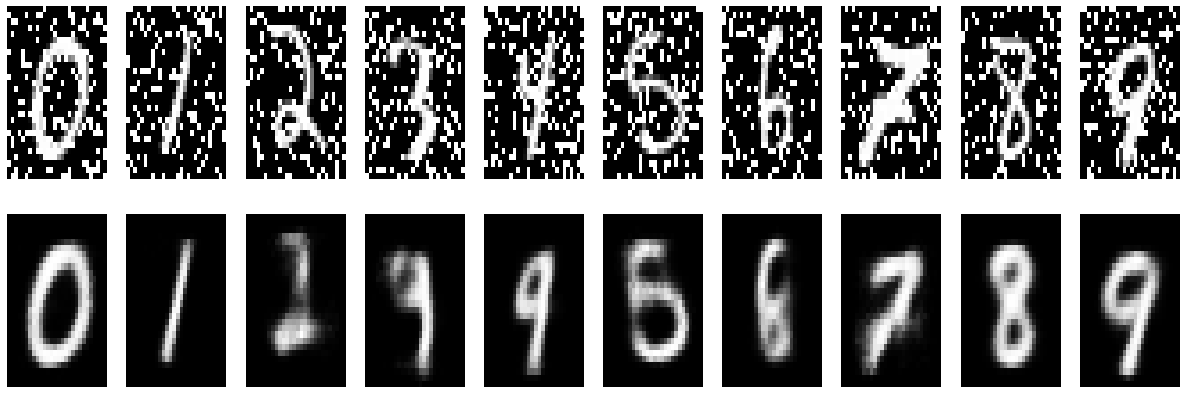

In [157]:
show_mnist_compare_multi(X_SPO2Test[ind_test], netSP02.forward(X_SPO2Test[ind_test]))

<b> Il a un peu de mal a détecter certaines valeurs mais nous arrivons tout de même a distinguer les chiffres

#### Salt Pepper 0.4

In [91]:
X_SP04 = add_noise_pepper(mnist_train_X_norm, p=0.4)
X_SP04Test = add_noise_pepper(mnist_test_X/255, p=0.4)


In [92]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderSP04 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderSP04 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netSP04 = Sequential(seqEncoderSP04 + seqDecoderSP04)
ce = BinaryCrossEntropy()

lossSP04 = MiniBatchGD(netSP04, ce, X_SP04, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:08<00:00,  7.89s/it]


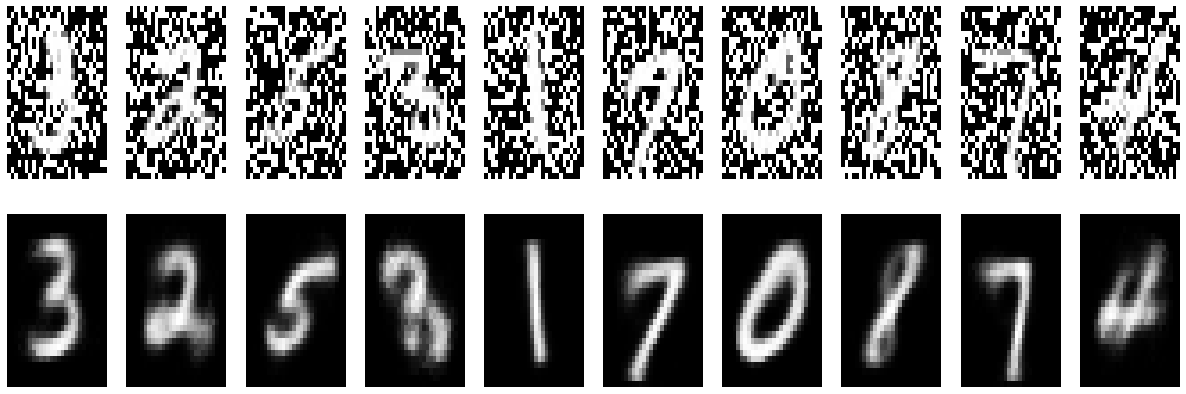

In [108]:
show_mnist_compare_multi(X_SP04[ind_test], netSP04.forward(X_SP04[ind_test]))

<b> Un bruit de slat and pepper de 40% rendent les  images quasiment difficile à reconnaitre avec l'oeil humain, mais le modèle à vraiment réussi à en tirer les informations et nous le voyons très clairement

#### Salt Pepper 0.6

In [93]:
X_SP06 = add_noise_pepper(mnist_train_X_norm, p=0.6)
X_SP06Test = add_noise_pepper(mnist_test_X/255, p=0.6)


In [94]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderSP06 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderSP06 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netSP06 = Sequential(seqEncoderSP06 + seqDecoderSP06)
ce = BinaryCrossEntropy()

lossSP06 = MiniBatchGD(netSP06, ce, X_SP06, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:16<00:00,  7.97s/it]


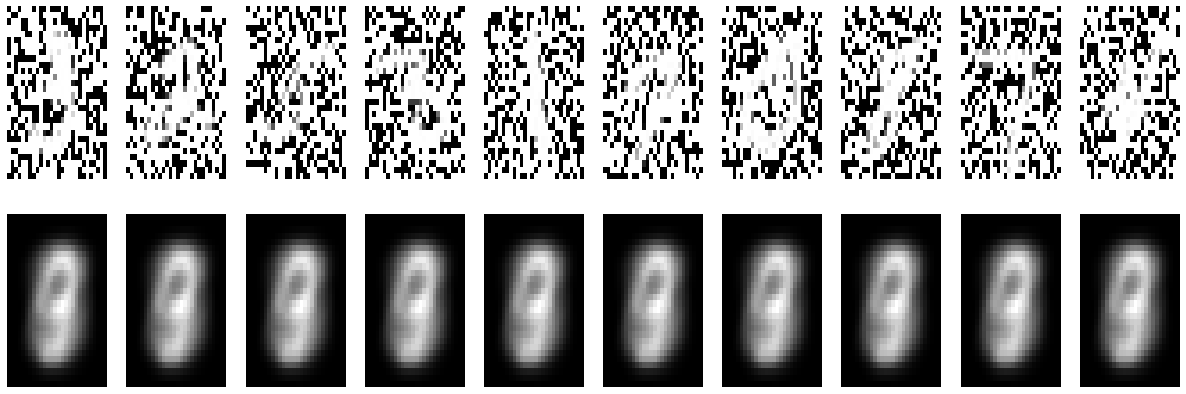

In [109]:
show_mnist_compare_multi(X_SP06[ind_test], netSP06.forward(X_SP06[ind_test]))

#### Salt Pepper 0.8

In [95]:
X_SP08 = add_noise_pepper(mnist_train_X_norm, p=0.8)

In [96]:
dimensionX = len(mnist_train_X_norm[0])
number_neurons_layer1 = 128
number_neurons_layer2 = 64
number_neurons_layer3 = 10

seqEncoderSP08 = [Linear(dimensionX, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer3), TanH()]
seqDecoderSP08 = [Linear(number_neurons_layer3, number_neurons_layer2), TanH(), Linear(number_neurons_layer2, number_neurons_layer1), TanH(), Linear(number_neurons_layer1, dimensionX), Sigmoide()]

netSP08 = Sequential(seqEncoderSP08 + seqDecoderSP08)
ce = BinaryCrossEntropy()

lossSP08 = MiniBatchGD(netSP08, ce, X_SP08, mnist_train_X_norm, 200, epochs=100, eps=1e-4, verbose=False)

100%|██████████| 100/100 [13:06<00:00,  7.86s/it]


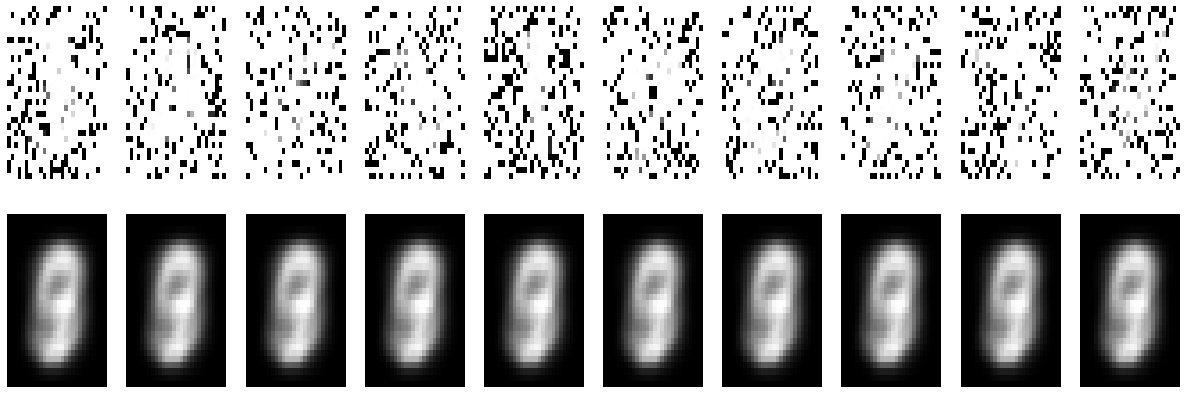

In [110]:
show_mnist_compare_multi(X_SP08[ind_test], netSP08.forward(X_SP08[ind_test]))

<b> Pour un bruit de 60% et 80% il est bien trop dur d'extraire de l'information, toutefois au vu des figures il s'agit peut être de sous apprentissage également.  
 Il faudrait donc tester avec un plus grand nombre d'epochs et/ou plus de données 

# Convolution Filtres Horizontaux

## Max Pooling

In [4]:
X_train_usps_reshape = np.array(X_train_usps.reshape(len(X_train_usps), -1, 1))
one_hot_y_usps = one_hot(Y_train_usps)

seqConv1 = Sequential([Conv1D(3,1,32,1), MaxPool1D(2,2), Flatten(), Linear(4064, 100), ReLu(), Linear(100, 10)])
ce = CrossEntropyLogSoftmax()

epochs = 10
eps = 10e-5

loss_seqConv1 = MiniBatchGD(seqConv1, ce, X_train_usps_reshape/2, one_hot_y_usps, 500, epochs=epochs, eps=eps, verbose=False)

100%|██████████| 10/10 [2:03:04<00:00, 738.48s/it] 


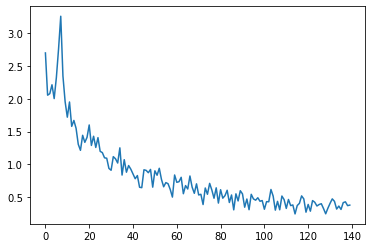

In [5]:
plt.plot(loss_seqConv1)

In [6]:
accuracy_argmax(X_train_usps_reshape[:100]/2, one_hot_y_usps[:100], seqConv1)

0.89

In [7]:
X_test_usps_reshape = np.array(X_test_usps.reshape(len(X_test_usps), -1, 1))
one_hot_y_test_usps = one_hot(Y_test_usps)

accuracy_argmax(X_test_usps_reshape[:100]/2, one_hot_y_test_usps[:100], seqConv1)

0.89

In [ ]:
ind_usps = 111

ind_test_usps = []
ind_test_usps.append((np.where(X_test_usps == 0)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 1)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 2)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 3)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 4)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 5)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 6)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 7)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 8)[0][ind_usps]))
ind_test_usps.append((np.where(X_test_usps == 9)[0][ind_usps]))

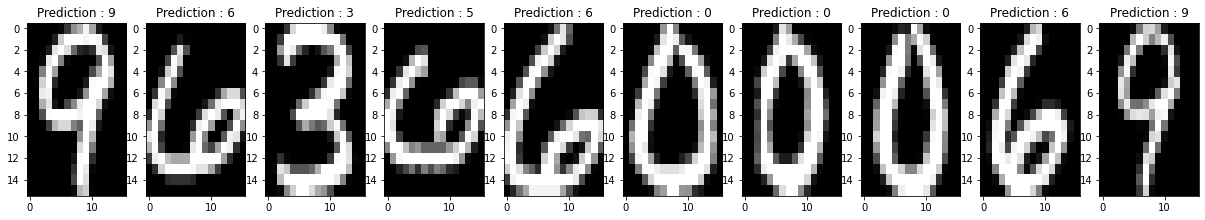

In [185]:
show_prediction(seqConv1, X_test_usps_reshape[ind_test_usps])

## Average Pooling

In [9]:
X_train_usps_reshape = np.array(X_train_usps.reshape(len(X_train_usps), -1, 1))
one_hot_y_usps = one_hot(Y_train_usps)

seqConv2 = Sequential([Conv1D(3,1,32,1), AvgPool1D(2,2), Flatten(), Linear(4064, 100), ReLu(), Linear(100, 10)])
ce = CrossEntropyLogSoftmax()

epochs = 10
eps = 10e-5

loss_seqConv2 = MiniBatchGD(seqConv2, ce, X_train_usps_reshape/2, one_hot_y_usps, 500, epochs=epochs, eps=eps, verbose=False)

100%|██████████| 10/10 [2:18:43<00:00, 832.39s/it] 


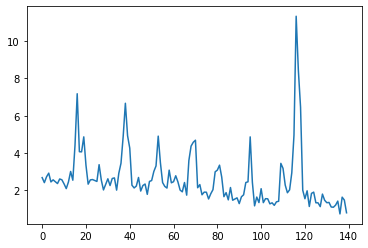

In [10]:
plt.plot(loss_seqConv2)

In [11]:
accuracy_argmax(X_train_usps_reshape[:1000], one_hot_y_usps[:1000], seqConv2)

0.947

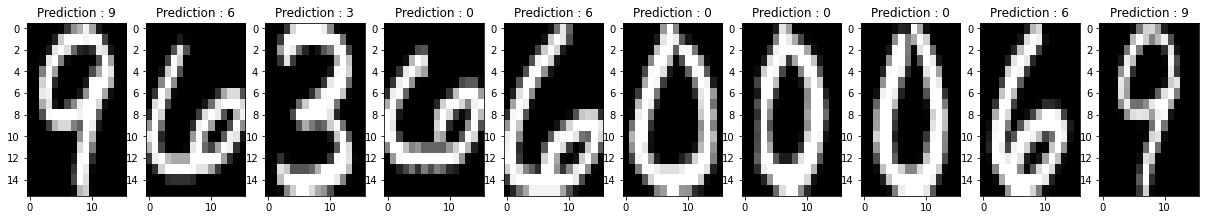

In [186]:
show_prediction(seqConv2, X_test_usps_reshape[:10])

# Convolution Filtres Horizontaux - Verticaux

## Max Pooling

In [12]:
X_train_usps_reshape = np.array(X_train_usps.reshape(len(X_train_usps), -1, 1))
one_hot_y_usps = one_hot(Y_train_usps)

seqConv3 = Sequential([Conv1D_2(3,1,32,1), MaxPool1D(2,2), Flatten(), Linear(8128, 100), ReLu(), Linear(100, 10)])
ce = CrossEntropyLogSoftmax()

epochs = 10
eps = 10e-5

loss_seqConv3 = MiniBatchGD(seqConv3, ce, X_train_usps_reshape/2, one_hot_y_usps, 500, epochs=epochs, eps=eps, verbose=False)

100%|██████████| 10/10 [4:16:43<00:00, 1540.35s/it] 


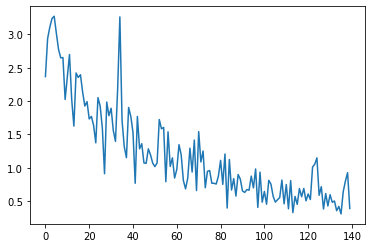

In [13]:
plt.plot(loss_seqConv3)

In [14]:
accuracy_argmax(X_test_usps_reshape[:100]/2, one_hot_y_test_usps[:100], seqConv3)

0.96

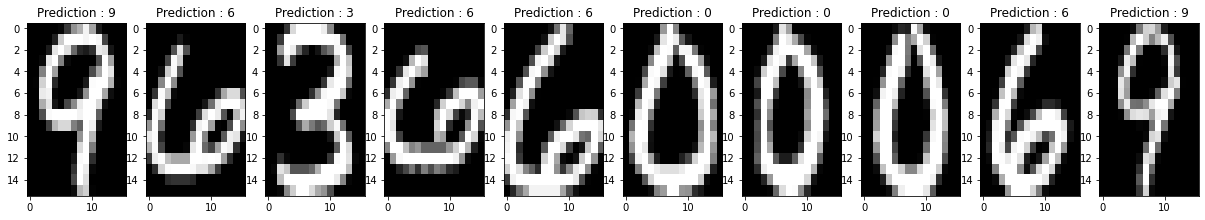

In [187]:
show_prediction(seqConv3, X_test_usps_reshape[:10])

## Average Pooling

In [ ]:
X_train_usps_reshape = np.array(X_train_usps.reshape(len(X_train_usps), -1, 1))
one_hot_y_usps = one_hot(Y_train_usps)

seqConv4 = Sequential([Conv1D_2(3,1,32,1), AvgPool1D(2,2), Flatten(), Linear(8128, 100), ReLu(), Linear(100, 10)])
ce = CrossEntropyLogSoftmax()

epochs = 3
eps = 10e-5

loss_seqConv4 = MiniBatchGD(seqConv4, ce, X_train_usps_reshape/2, one_hot_y_usps, 500, epochs=epochs, eps=eps, verbose=False)

In [ ]:
plt.plot(loss_seqConv4)

In [ ]:
accuracy_argmax(X_test_usps_reshape[:100]/2, one_hot_y_test_usps[:100], seqConv4)

<b> Concernant les convolutions, on constate tout d'abord que des convolutions uniquement ed 1 dimension permettent déjà d'avoir de très bons résultats.  
  
La comparaison entre les Conv1D avec uniquement des filtres horizontaux et les Conv1D filtres Horizontaux - Verticaux est bien nette. Cette différence est tout à fait et était attendu.  
Avec des scores de 0.946 avec du MaxPooling

Enfin en ce qui concerne le MaxPooling et le AvgPooling, nous constatons que le MaxPooling va avoir avoir une loss qui va descendre directement on converge assez vite pour ensuite converger petit à petit.  
Alors que pour l'AvgPooling nous avons plutôt un convergence lente mais constante.